In [18]:
import sys
sys.path.insert(0, '/Users/james/Desktop/DRL_Hedging')
import numpy as np
import matplotlib.pyplot as plt
from financial_models.asset_price_models import StochasticVolatilityModel
from financial_models.option_price_models import BSMSABR
from hedging_env_gymnasium_a import HedgingEnv
from baseline_agent import DeltaNeutralAgent
from tqdm import tqdm
import seaborn as sns
from Utils import evaluate_delta_policy


seed = 345
np.random.seed(seed)


mu = 0
D = 5
T = 10
num_steps = T*D
s_0 = 100
strike_price = s_0
sigma = 0.15
r = 0
trading_cost_para=0.003
L=100
v=0.6
rho=-0.4

apm = StochasticVolatilityModel(mu=mu, v=v, rho=rho, dt = 1/(252*D), s_0=s_0, sigma_0=sigma)
opm = BSMSABR(strike_price=strike_price, risk_free_interest_rate=r, T=T/252, dt=1/(252*D),v=v, rho=rho)
env = HedgingEnv(asset_price_model=apm, D=D, T=T, num_steps=num_steps, trading_cost_para=trading_cost_para,r=r,
                L=L, strike_price=strike_price, initial_holding_delta=False, mode="RA",
                option_price_model=opm)



In [19]:
s,_ = env.reset()
liability=s[3]*L
liability

119.26764249801636

In [20]:
save_path = "./result_analysis"
# Initialize agent
agent = DeltaNeutralAgent()
rewards_delta, costs_delta, vol_delta = evaluate_delta_policy(env,agent,num_episodes=10000,pnl=False)




100%|██████████| 10000/10000 [03:09<00:00, 52.66it/s]

reward mean:-149.17104288492453,
, reward std:57.085946342168604, 
, costs mean:96.3932708147467, costs std:28.08966533838506


In [21]:
np.save(f"{save_path}/delta_hedging_rewards_sabr_3e-3.npy", rewards_delta)
#np.save(f"{save_path}/delta_hedging_costs_sabr_3e-3.npy", costs_delta)

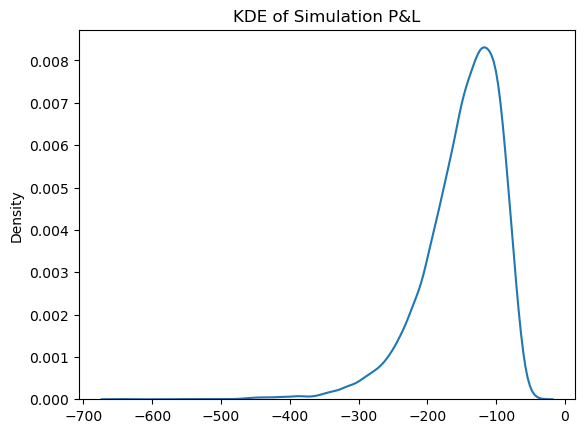

In [22]:

ax = sns.kdeplot(rewards_delta)
ax.set_title('KDE of Simulation P&L')
plt.show()

In [23]:


# Run simulations
num_simulations = 1000
reward_array = np.zeros(num_simulations)
for i in tqdm(range(num_simulations)):
    episode_reward = 0
    state,info = env.reset()
    done = False
    while not done:
        action = [0]
        state, reward, done, _ ,info = env.step(action)
        episode_reward += reward
    reward_array[i] = episode_reward

reward_array.mean()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/james/Desktop/DRL_Hedging/financial_models/option_price_models.py:78: RuntimeWarning: invalid value encountered in double_scalars
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)
/Users/james/Desktop/DRL_Hedging/financial_models/option_price_models.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)
100%|██████████| 1000/1000 [00:17<00:00, 58.32it/s]


-1505.905421910874

In [24]:
reward_array.max()

43.417530225855806

In [25]:
reward_array.std()


1306.842002453237

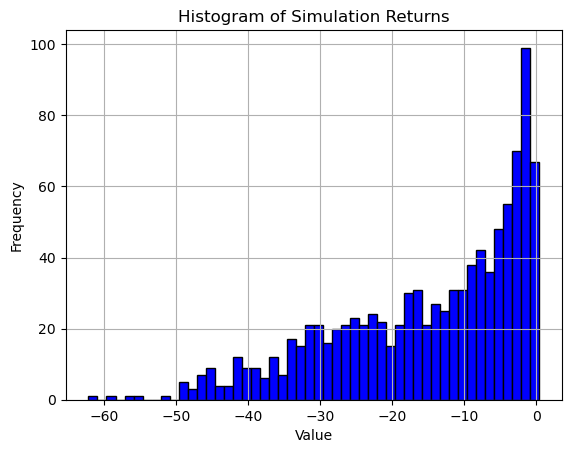

In [26]:
# Plotting the histogram
plt.hist(reward_array/L, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Simulation Returns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [27]:
# Initialize agent
agent = DeltaNeutralAgent()

proportion = np.zeros(1000)
for i in tqdm(range(1000)):
    state,info = env.reset()
    done = False
    count=0
    reward_history = np.zeros(env.num_steps)
    while not done:
        action = agent.act(state, info['delta'])
        state, reward, done, _ ,info = env.step(action)
        reward_history[count]=reward
        count+=1
    proportion[i] = reward_history[0]/reward_history.sum()
print(proportion.mean())





100%|██████████| 1000/1000 [00:20<00:00, 49.76it/s]

0.37020701820082025
